# LTAT.02.006 Andmeteaduse meetodid

## 5. praktikum - Mudelite võrdlemine, liiklusõnnetuste jaotuse analüüs


Praktikumi eesmärk on uurida, kas liiklusõnnetuste jaotus on nädalapäevade lõikes ühtlane või mitte. Kui ei ole ühtlane, siis tuleks sobitada treeningandmetel kasvava keerukusega mudeleid ning leida valideerimisandmete järgi sobiv keerukusaste. Seejuures võiks nii treeningandmeid, valideerimisandmeid kui testandmeid olla kõiki umbes 3 aasta jagu. Lõpuks tuleks sobitada leitud keerukusega mudel kogu andmestikule ning teha järeldused liiklusõnnetuste jaotuse kohta nädalapäevade lõikes.

All on toodud kood, mis on õige pisut muudetud versioon loengu slaidide joonistamise koodist. Kontrolliks võiks vaadata, et aasta 2016 jaotus klapiks sellega, mis on toodud selles [Postimehe artiklis](https://www.postimees.ee/4054657/graafik-eesti-liikluse-koige-eluohtlikum-paev-ei-olegi-nadalavahetusel).


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import scipy.stats

In [2]:
d = pd.read_csv('Inimkannatanutega_liiklusonnetused.csv',sep=';')
d.head()

,Juhtumi nr,Kuupäev,Sõidukeid,Isikuid,Hukkunuid,Vigastatuid,Maakond,Omavalitsus,Asustus,Bussi osalusel,...,Tee element [2],Tee rajatis [1],Tee rajatis [2],Tee kurvilisus,Tee mägisus,Teekate,Teekatte seisund [1],Teekatte seisund [2],Tüüpskeem [1],Tüüpskeem [2]
0,3100190034687,19.01.2019,2,2,0,1,Viljandi maakond,Viljandi linn,Märkimata,0,...,T-kujuline ristmik,Ristmik,Reguleerimata ristmik - liiklusmärkidega,Sirge tee,Kerge langus,Püsikate,Jäised olud,Töödeldud pinnaga jäätunud kate,Muu liiklusõnnetus,Muu liikluskonflikt.
1,2602110032835,02.04.2011,1,1,0,1,Märkimata,Märkimata,Märkimata,0,...,Erielemendita teelõik,Rajatis puudub,Rajatis puudub,Sirge tee,Tasane tee,Püsikate,Märg,Märg,Ühesõidukiõnnetus,Sõiduk kaotab teelõigul või ristmikul juhitavu...
2,3100190336196,17.06.2019,1,1,0,1,Järva maakond,Paide linn,Märkimata,0,...,Erielemendita teelõik,Rajatis puudub,Rajatis puudub,Sirge tee,Tasane tee,Püsikate,Kuiv,Kuiv,Ühesõidukiõnnetus,Sõiduk kaotab teelõigul või ristmikul juhitavu...
3,3130160036397,23.05.2016,1,2,0,1,Harju maakond,Tallinn,Kristiine linnaosa,0,...,T-kujuline ristmik,Rajatis puudub,Rajatis puudub,Sirge tee,Tasane tee,Püsikate,Kuiv,Kuiv,Sõiduki konflikt jalakäijaga,Tagurdava sõiduki konflikt jalakäijaga.
4,3100130095584,25.09.2013,1,2,0,1,Harju maakond,Tallinn,Põhja-Tallinna linnaosa,0,...,Erielemendita teelõik,Rajatis puudub,Rajatis puudub,Sirge tee,Tasane tee,Püsikate,Kuiv,Kuiv,Sõiduki konflikt jalakäijaga,Sõiduki konflikt teise sõiduki või muu takistu...


Järjestame andmed juhuslikult.


In [3]:
rng = np.random.default_rng(5)
d['juhus'] = np.random.uniform(len(d))
d = d.sort_values('juhus')

### Andmete täiendamine ja uurimine


1. Lisage andmetele juurde veerud 'nädalapäev', 'aasta' ja 'kuu'.


In [4]:
d['nädalapäev'] = [datetime.datetime.strptime(x, '%d.%m.%Y').weekday() for x in d['Kuupäev']]
d['aasta'] = [datetime.datetime.strptime(x, '%d.%m.%Y').year for x in d['Kuupäev']]
d['kuu'] = [datetime.datetime.strptime(x, '%d.%m.%Y').month for x in d['Kuupäev']]

In [8]:
d.head()

,Juhtumi nr,Kuupäev,Sõidukeid,Isikuid,Hukkunuid,Vigastatuid,Maakond,Omavalitsus,Asustus,Bussi osalusel,...,Tee mägisus,Teekate,Teekatte seisund [1],Teekatte seisund [2],Tüüpskeem [1],Tüüpskeem [2],juhus,nädalapäev,aasta,kuu
0,3100190034687,19.01.2019,2,2,0,1,Viljandi maakond,Viljandi linn,Märkimata,0,...,Kerge langus,Püsikate,Jäised olud,Töödeldud pinnaga jäätunud kate,Muu liiklusõnnetus,Muu liikluskonflikt.,9911.419398,5,2019,1
8458,2502120082816,29.09.2012,1,1,0,1,Saare maakond,Leisi vald,Märkimata,0,...,Tasane tee,Kruusatee,Märg,Märg,Ühesõidukiõnnetus,Sõiduk kaotab teelõigul või ristmikul juhitavu...,9911.419398,5,2012,9
8459,3100190735920,19.12.2019,1,2,0,1,Ida-Viru maakond,Kohtla-Järve linn,Järve linnaosa,0,...,Tasane tee,Püsikate,Kuiv,Kuiv,Sõiduki konflikt jalakäijaga,Sõiduki konflikt teelõiku paremalt poolt ületa...,9911.419398,3,2019,12
8460,3130150084483,02.12.2015,1,2,0,2,Harju maakond,Anija vald,Märkimata,0,...,Tasane tee,Püsikate,Märg,Märg,Ühesõidukiõnnetus,Sõiduk kaotab teelõigul või ristmikul juhitavu...,9911.419398,2,2015,12
8461,3100130011328,31.03.2013,1,2,0,1,Harju maakond,Tallinn,Kesklinna linnaosa,0,...,Tasane tee,Püsikate,Märg,Märg,Sõiduki konflikt jalakäijaga,Ristmikule siseneva sõiduki konflikt paremalt ...,9911.419398,6,2013,3


2. Joonistage tulpdiagramm, kuhu on iga aasta jaoks kantud toimunud liiklusõnnetuste arv vastaval aastal.


In [5]:
aastakaupa = d.groupby('aasta')

In [6]:
aastakaupa.size()

aasta
2011    1448
2012    1357
2013    1359
2014    1405
2015    1375
2016    1463
2017    1413
2018    1474
2019    1403
dtype: int64

In [7]:
aastakaupa = d["aasta"].value_counts()

In [8]:
aastakaupa

aasta
2018    1474
2016    1463
2011    1448
2017    1413
2014    1405
2019    1403
2015    1375
2013    1359
2012    1357
Name: count, dtype: int64

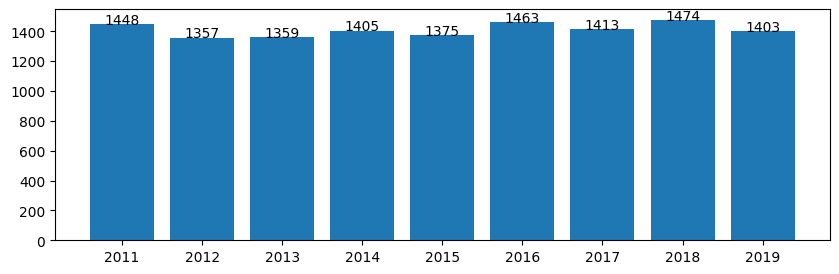

In [9]:
aastad = sorted(aastakaupa.index)
plt.figure(figsize=(10,3))
plt.bar(aastad, aastakaupa[aastad])
plt.xticks(aastad)
for a in aastad:
    plt.text(a,aastakaupa[a],aastakaupa[a],horizontalalignment='center')
plt.show()

3. Kandke horisontaalsele tulpdiagrammile nädalapäevade kaupa 2016. aastal toimunud õnnetuste sagedused. _Vihje:_ Uurige matplotlibi `barh` käsklust.


In [15]:
päevanimed = np.array(['E','T','K','N','R','L','P'])
#sagedused_2016 = d[d['aasta'] == 2016].groupby('nädalapäev').size()
sagedused_2016 = pd.Series(päevanimed[d.loc[d['aasta'] == 2016, 'nädalapäev']]).value_counts()

In [16]:
sagedused_2016

T    225
E    221
R    221
K    210
L    200
N    196
P    190
Name: count, dtype: int64

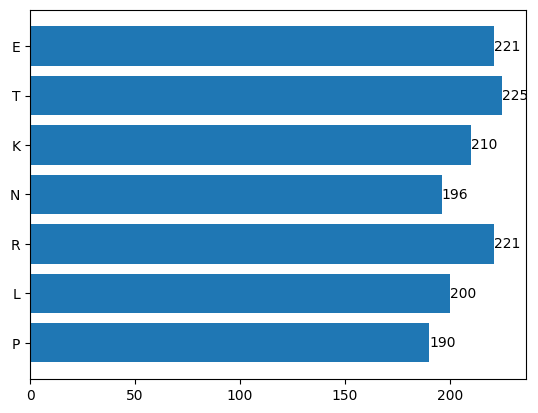

In [17]:
päevad_tagurpidi = np.array(list(reversed(päevanimed)))
plt.barh(päevad_tagurpidi,sagedused_2016[päevad_tagurpidi])
for p in päevad_tagurpidi:
    plt.text(sagedused_2016[p],p,sagedused_2016[p],verticalalignment='center')
plt.show()

### Treening-, test- ja valideerimisandmestiku eraldamine


4. Jagage andmestik kolmeks: treening-, test- ja valideerimisandmestikuks. Treening- ja valideerimisandmestikku jätke 2800 kirjet, testandmestikku kõik ülejäänud.

Kas peaks andmed kuupäeva järgi ära sorteerima või jätma sorteerimata?


In [20]:
# oletame, et meil on uurimiseks antud umbes 2 aasta jagu andmeid
n_treen = 2800
d_treen = d[:n_treen]

# ja hiljem lisame veel umbes 2 aasta jagu andmeid
n_valid = 2800
d_valid = d[n_treen:(n_treen+n_valid)]

# ja lõpuks testime ülejäänud veel umbes 5 aasta jagu andmetel
n_test = len(d)-n_treen-n_valid
d_test = d[(n_treen+n_valid):]

5. Leidke treeningandmestikus iga liiklusõnnetuse toimumise sagedus igal nädalapäeval ja kandke tulemus tulpdiagrammile.


In [ ]:
sagedused = pd.Series(päevanimed[d_treen['nädalapäev']]).value_counts()
sagedused

R    452
L    442
E    413
N    397
T    381
K    369
P    346
Name: count, dtype: int64

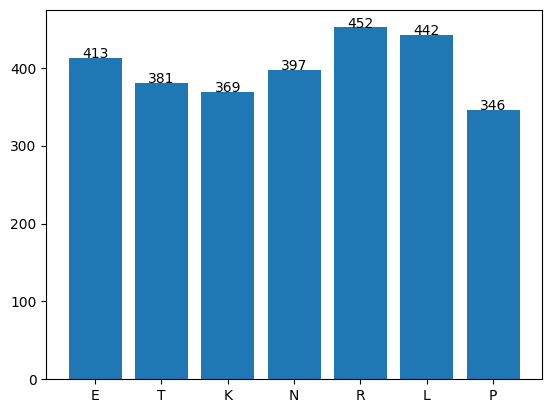

In [ ]:
plt.bar(päevanimed, sagedused[päevanimed])
for p in päevanimed:
    plt.text(p,sagedused[p],sagedused[p],horizontalalignment='center')
plt.show()

### Lihtsaim mudel -- ühtlane jaotus


Nüüd on paras aeg alustada liiklusõnnetuste jaotuse modelleerimist. Selleks koostame nüüd mudeli, kus võtame eelduseks ühtlase jaotuse ja testime saadud mudeli usutavust.

Küsimused enne lahendamist:

-   Kuidas kasutada treening-, valideerimis- ja testandmestikke?
-   Milline peaks olema usutav mudel ja kuidas me seda kontrollime?
-   Kuidas toimub testimine, mille põhjal saab öelda, kas on usutav?


6. Looge treeningandmestiku põhjal ühtlase jaotuse mudel.


In [25]:
m1 = pd.Series(
	np.repeat(1/7, 7),
	index=päevanimed
)

7. Nüüd saab asuda mudeli testimisele. Mõõdikuna kasutage loengus defineeritud mõõdikut $\chi^2$, mis järgib ligikaudselt hii-ruut jaotust vabadusastmete arvuga 6. Leidke selle mõõdiku väärtus treeningandmetel.

$$\chi^2 = \sum_{i=1}^{k}\frac{(n\cdot p_i - n_i)^2}{n\cdot p_i}.$$


In [26]:
m1_oodatav = len(d_treen)*m1
m1_oodatav

E    400.0
T    400.0
K    400.0
N    400.0
R    400.0
L    400.0
P    400.0
dtype: float64

In [ ]:
#m1_hiiruut = scipy.stats.chisquare(sagedused[päevanimed], m1_oodatav)

m1_hiiruut = np.sum(
	(m1_oodatav - sagedused)**2 / m1_oodatav
)

m1_hiiruut

np.float64(22.209999999999997)

8. Leidke selle mõõdiku järgi tegelike treeningandmete põhjal eksperimentaalne p-väärtus, kus nullhüpoteesiks on treeningandmetel leitud ühtlase jaotuse mudel. Selleks genereerige mudelist 10000 andmestikku, kus iga andmestik on sama suur treeningandmestik. Seejärel saate leida vaadeldava statistiku väärtuse iga katse korral. Joonistage eksperimentaalse statistiku väärtus ja teoreetiline hii-ruut jaotus samale graafikule.


In [35]:
rng = np.random.default_rng(0)
n_iter = 10000
m1_hiiruudud = np.zeros(n_iter)
for i in range(n_iter):
    m1_andmed = np.random.choice(päevanimed, size=len(d_treen), p=m1)
    m1_sagedused = pd.Series(m1_andmed).value_counts()
    m1_hiiruudud[i] = np.sum(
	    (m1_oodatav - m1_sagedused)**2 / m1_oodatav
    )

In [36]:
m1_experimentaalne_pväärtus = np.mean(m1_hiiruudud>=m1_hiiruut)
m1_experimentaalne_pväärtus

np.float64(0.0006)

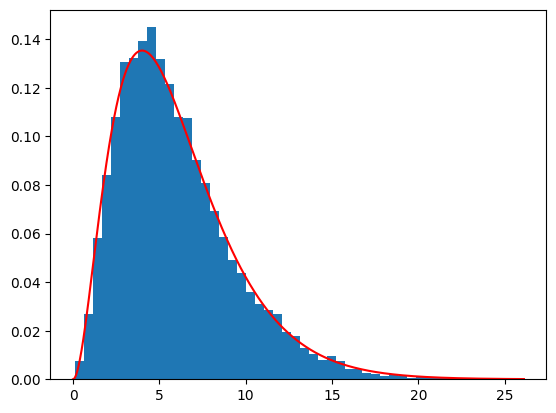

In [37]:
plt.hist(m1_hiiruudud,bins=50,density=True)
x_values = np.linspace(0,max(m1_hiiruudud),1000)
# 7 nädalapäeva, seega hii-ruut jaotus 7-1=6 vabadusastmega
plt.plot(x_values,scipy.stats.chi2(df=6).pdf(x_values),'-',color='red')
plt.show()

In [39]:
# Sama tulemuse saab kui kasutada chisquare testi funktsiooni.
scipy.stats.chisquare(sagedused)

Power_divergenceResult(statistic=np.float64(22.21), pvalue=np.float64(0.0011092083814879315))

### Keerulisemad mudelid


Nagu ka loengust teada on, siis lihtne ühtlase jaotuse mudel ei sobi nendele andmetele. Koostame nüüd veel kuus tõenäosuslikku mudelit, kus igal järgmisel mudelil on üks lisaparameeter. Ehk kui esimesel mudelil oli kõigil nädalapäevadel sama tõenäosus liiklusõnnetuse esinemiseks, siis teisel mudelil on nädalapäevad jaotatud kaheks: ühtedel on üks tõenäosus, teistel teine. Kolmandas mudelis on nädalapäevad jaotatud kolme gruppi jne.


9. Kõigepealt tuleks välja mõelda loogika, mille järgi me hakkame nädalapäevi gruppidesse jagama. Lähtume taaskord loengust: vaatame sagedusi nädalapäevade kaupa ja leiame, millise kahe järjestiku sageduse vahel on kõige suurem vahe. Sagedamad nädalapäevad langevad ühte gruppi, ülejäänud teise. Leidke, millised nädalapäevad langevad selle loogika alusel ühte, millised teise gruppi.


In [40]:
sagedused_sort = sagedused.sort_values()
sagedused_sort

P    346
K    369
T    381
N    397
E    413
L    442
R    452
Name: count, dtype: int64

10. Koostage nüüd uus tõenäosuslik mudel, kus gruppidesse langemise tõenäosused on vastavalt gruppide suurusele. Grupisiseselt on aga jaotus nädalapäevade vahel ühtlane.


In [46]:
g1 = np.mean(sagedused["L"]) / sum(sagedused)
g2 = np.mean(sagedused[["E", "T", "K", "N", "R", "P"]]) / sum(sagedused)

print(g1, g2)

m2 = pd.Series(
	[g2, g2, g2, g2, g2, g1, g2],
	index=päevanimed
)
m2

0.15785714285714286 0.14035714285714285


E    0.140357
T    0.140357
K    0.140357
N    0.140357
R    0.140357
L    0.157857
P    0.140357
dtype: float64

11. Analoogselt toimides koostage ülejäänud 5 mudelit. Leidke suuruselt järgmine hüpe liiklusõnnetuste toimumise sagedustes, seejärel koostage nädalapäevadest kolm gruppi ja koostage vastavalt gruppidele tõenäosuslik mudel. Seejärel samamoodi 4, 5, 6 ja 7 grupiga (kui 7 gruppi, siis iga nädalapäev on üksinda omas grupis).


In [47]:
g1 = np.mean(sagedused["L"]) / sum(sagedused)
g2 = np.mean(sagedused[["E", "K", "N", "R"]]) / sum(sagedused)
g3 = np.mean(sagedused[["T", "P"]]) / sum(sagedused)

print(g1, g2, g3)

m3 = pd.Series(
	[g2, g3, g2, g2, g2, g1, g3],
	index=päevanimed
)
m3

0.15785714285714286 0.145625 0.12982142857142856


E    0.145625
T    0.129821
K    0.145625
N    0.145625
R    0.145625
L    0.157857
P    0.129821
dtype: float64

In [ ]:
g1 = np.mean(sagedused["L"]) / sum(sagedused)
g2 = np.mean(sagedused[["E", "N", "R"]]) / sum(sagedused)
g3 = np.mean(sagedused[["T", "P"]]) / sum(sagedused)
g4 = np.mean(sagedused[["K"]]) / sum(sagedused)


m4 = pd.Series(
	[g2, g3, g4, g2, g2, g1, g3],
	index=päevanimed
)
m4

E    0.150238
T    0.129821
K    0.131786
N    0.150238
R    0.150238
L    0.157857
P    0.129821
dtype: float64

In [49]:
g1 = np.mean(sagedused["L"]) / sum(sagedused)
g2 = np.mean(sagedused[["E", "N"]]) / sum(sagedused)
g3 = np.mean(sagedused[["T", "P"]]) / sum(sagedused)
g4 = np.mean(sagedused[["K"]]) / sum(sagedused)
g5 = np.mean(sagedused[["R"]]) / sum(sagedused)


m5 = pd.Series(
	[g2, g3, g4, g2, g5, g1, g3],
	index=päevanimed
)
m5

E    0.144643
T    0.129821
K    0.131786
N    0.144643
R    0.161429
L    0.157857
P    0.129821
dtype: float64

In [50]:
g1 = np.mean(sagedused["L"]) / sum(sagedused)
g2 = np.mean(sagedused[["E", "N"]]) / sum(sagedused)
g3 = np.mean(sagedused[["T"]]) / sum(sagedused)
g4 = np.mean(sagedused[["K"]]) / sum(sagedused)
g5 = np.mean(sagedused[["R"]]) / sum(sagedused)
g5 = np.mean(sagedused[["R"]]) / sum(sagedused)
g6 = np.mean(sagedused[["P"]]) / sum(sagedused)


m6 = pd.Series(
	[g2, g3, g4, g2, g5, g1, g6],
	index=päevanimed
)

m6

E    0.144643
T    0.136071
K    0.131786
N    0.144643
R    0.161429
L    0.157857
P    0.123571
dtype: float64

In [51]:
m7 = sagedused/sum(sagedused)
m7

R    0.161429
L    0.157857
E    0.147500
N    0.141786
T    0.136071
K    0.131786
P    0.123571
Name: count, dtype: float64

In [52]:
mudelid = [m1,m2,m3,m4,m5,m6,m7]

12. Leidke iga mudeli ennustuste ja tegelike treening-, valideerimis- ja testandmestike põhjal eelnevalt defineeritud hii-ruut jaotusega mõõdiku väärtus nii treening- kui valideerimisandmestiku jaoks. Kandke tulemused graafikule ning valige parim mudel. Kommenteerige mudelit ja tema usutavust testandmestiku põhjal.


Leiame hii-ruut statistiku ja eukleidilise kauguse treeningandmestikul


In [53]:
mudelid_oodatav = [ m*n_treen for m in mudelid]

In [54]:
mudelid_kaugus = [sum(((sagedused-mudelid_oodatav[i])**2)/mudelid_oodatav[i]) for i in range(len(mudelid))]
mudelid_kaugus

[22.21,
 17.368956743002546,
 10.520690507254137,
 5.4900781929515166,
 2.0010562602951416,
 0.3160493827160493,
 0.0]

Leiame valideerimisandmestikul


In [55]:
mudelid_valid_oodatav = [ m*n_valid for m in mudelid]

In [56]:
valid_sagedused = pd.Series(päevanimed[d_valid['nädalapäev']]).value_counts()
valid_sagedused

R    455
L    437
E    408
K    404
N    389
T    388
P    319
Name: count, dtype: int64

In [59]:
mudelid_valid_kaugus = [
	sum(((valid_sagedused - mudelid_valid_oodatav[i])**2)/mudelid_valid_oodatav[i]) for i in range(len(mudelid))
]
mudelid_valid_kaugus

[28.25,
 24.75630663304664,
 13.527762541270269,
 16.04273483002194,
 11.149613914811026,
 6.286122115953418,
 5.8535428839605]

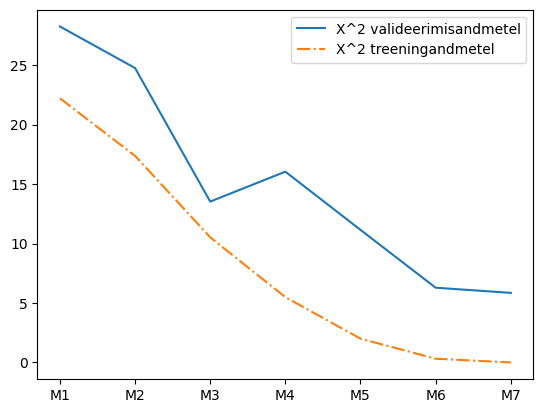

In [60]:
plt.plot(['M%i'%i for i in range(1,8)],mudelid_valid_kaugus,'-',label='X^2 valideerimisandmetel')
plt.plot(['M%i'%i for i in range(1,8)],mudelid_kaugus,'-.',label='X^2 treeningandmetel')
plt.legend()
plt.show()

Leiame testandmestikul


In [61]:
mudelid_test_oodatav = [ m*n_test for m in mudelid]

In [62]:
test_sagedused = pd.Series(päevanimed[d_test['nädalapäev']]).value_counts()
test_sagedused

L    1126
R    1093
E    1015
K    1011
N    1009
T     940
P     903
Name: count, dtype: int64

In [63]:
mudelid_test_kaugus = [sum(((test_sagedused-mudelid_test_oodatav[i])**2)/mudelid_test_oodatav[i]) for i in range(len(mudelid))]
mudelid_test_kaugus

[36.116387205861635,
 22.06471981934087,
 5.599158873452153,
 13.10846869270792,
 9.750857202944285,
 10.463385624864868,
 11.008478070317029]

In [64]:
mudelid_test_eukl = [np.sqrt(sum((test_sagedused/sum(test_sagedused)-mudelid[i])**2)) for i in range(len(mudelid))]
mudelid_test_eukl

[np.float64(0.0269628457762407),
 np.float64(0.02089125337549712),
 np.float64(0.01064357695848267),
 np.float64(0.01610752717536026),
 np.float64(0.013851088168273792),
 np.float64(0.014311158668648566),
 np.float64(0.014707303557567181)]

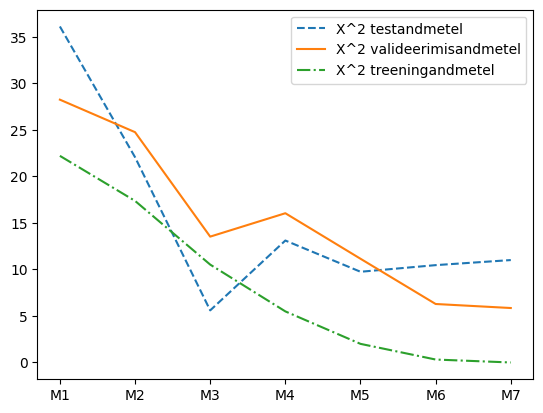

In [65]:
plt.plot(['M%i'%i for i in range(1,8)],mudelid_test_kaugus,'--',label='X^2 testandmetel')
plt.plot(['M%i'%i for i in range(1,8)],mudelid_valid_kaugus,'-',label='X^2 valideerimisandmetel')
plt.plot(['M%i'%i for i in range(1,8)],mudelid_kaugus,'-.',label='X^2 treeningandmetel')
plt.legend()
plt.show()